# Efficient Gaussian Random Field Inference on Graphs - Bayes Opt on the Traffic Dataset

This notebook contains the following:

1. Load the traffic dataset
2. (Opt) Visualize the dataset
3. Run Bayes Opt with different kernels
4. Run Bayes Opt with GRF, with different walks per node

## Setup

In [67]:
import tensorflow as tf
import numpy as np
import scipy.special
import gpflow
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output
import networkx as nx
from gpflow.utilities import print_summary
import tensorflow_probability as tfp
import seaborn as sns
from tqdm import tqdm
import pandas as pd

import sys
import os
project_root = os.path.abspath("../..")
sys.path.append(project_root)

from efficient_graph_gp.graph_kernels import get_normalized_laplacian
from efficient_graph_gp.gpflow_kernels import GraphDiffusionFastGRFKernel, GraphDiffusionPoFMKernel, GraphDiffusionKernel, GraphGeneralPoFMKernel, GraphGeneralFastGRFKernel
from utils import compute_fro
from traffic_utils.preprocessing import load_PEMS
from traffic_utils.plotting import plot_PEMS

In [26]:
# Load and preprocess the PEMS dataset

np.random.seed(1111)
num_eigenpairs = 500
dataset = 'PeMS-Bay-new'
num_train = 250

G, data_train, data_test, data = load_PEMS(num_train=num_train)
x_train, y_train = data_train
x_test, y_test = data_test
x, y = data
orig_mean, orig_std = np.mean(y_train), np.std(y_train)
y_train = (y_train-orig_mean)/orig_std
y_test = (y_test-orig_mean)/orig_std

X_train = tf.convert_to_tensor(x_train)
X_full = tf.convert_to_tensor(x)
Y_train = tf.convert_to_tensor(y_train)

adjacency_matrix = nx.to_numpy_array(G)  # Converts to NumPy adjacency matrix
print(adjacency_matrix.shape)  # Check matrix size

/Users/matthew/Documents/Efficient Gaussian Process on Graphs/Efficient_Gaussian_Process_On_Graphs/experiments/traffic_dataset/traffic_utils/preprocessing.py:90: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again; shapely 2.1 will not have this compatibility.
  G = pickle.load(f)


epsg:4326
(1016, 1016)


/Users/matthew/Documents/Efficient Gaussian Process on Graphs/Efficient_Gaussian_Process_On_Graphs/venv/lib/python3.11/site-packages/osmnx/convert.py:381: FutureWarning: <class 'geopandas.array.GeometryArray'>._reduce will require a `keepdims` parameter in the future
  dupes = edges[mask].dropna(subset=["geometry"])


In [27]:
def gp_training(X,Y,X_new, graph_kernel):
    model = gpflow.models.GPR(data=(X, Y), kernel=graph_kernel, mean_function=None,noise_variance=0.01)
    
    # # Explicitly set dtype to float32
    # dtype = tf.float64
    # # Assign Uniform prior with explicitly cast float32 values
    # model.kernel.beta.prior = tfp.distributions.Uniform(
    #     low=tf.constant(0.0, dtype=dtype), 
    #     high=tf.constant(2.0, dtype=dtype)
    # )
    
    gpflow.optimizers.Scipy().minimize(model.training_loss, model.trainable_variables)
    mean, variance = model.predict_f(X_new)
    stddev = tf.sqrt(variance)
    return model, mean, stddev

def configure_model(model, hyperparameters):
    model.kernel.beta.assign(hyperparameters['beta'])
    model.kernel.sigma_f.assign(hyperparameters['sigma_f'])
    model.likelihood.variance.assign(hyperparameters['variance'])
    return model

def configure_model_general(model, hyperparameters):
    model.kernel.modulator_vector.assign(hyperparameters['modulator_vector'])
    model.likelihood.variance.assign(hyperparameters['variance'])
    return model

def gp_inference(model, X_new):
    mean, variance = model.predict_f(X_new)
    stddev = tf.sqrt(variance)
    return mean, stddev

def evaluate(model, x_test, y_test, quiet=False):
    
    train_likelihood = model.log_marginal_likelihood().numpy()
    
    mean, cov = model.predict_f(x_test, full_cov=True)
    l2_error = orig_std * np.linalg.norm(y_test.ravel() - mean.numpy().ravel()) / len(y_test.ravel())
    
    mean, cov = tf.reshape(mean, [-1]), cov[0]
    cov = cov + tf.linalg.diag(tf.fill([len(y_test)], model.likelihood.variance))
    dist = tfp.distributions.MultivariateNormalTriL(mean, cov)
    test_likelihood = dist.log_prob(tf.reshape(y_test, [-1])).numpy()
    
    if not quiet:
        print(f"Train likelihood: {train_likelihood}")
        print(f"L2 error: {l2_error}")
        print(f"Test likelihood: {test_likelihood}")
    
    return train_likelihood, l2_error, test_likelihood

## Learn A Set of Good Hyperparameters with General PoFM

In [286]:
MAX_WALK_LENGTH = 4

In [287]:
x,y = data
y_avg = np.mean(y)
y_std = np.std(y)
X = tf.convert_to_tensor(x)
Y = tf.convert_to_tensor((y - y_avg)/y_std)

In [288]:
# The normalized laplacian is used
graph_kernel = GraphGeneralPoFMKernel(adjacency_matrix,
                                      max_walk_length=MAX_WALK_LENGTH,
                                      normalize_laplacian=True) # note a random initialization of modulation function is used.

model, mean, stddev = gp_training(X, Y, X, graph_kernel)
print_summary(model)

╒═════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤════════════════════════════════╕
│ name                        │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │ value                          │
╞═════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪════════════════════════════════╡
│ GPR.kernel.modulator_vector │ Parameter │ Identity         │         │ True        │ (4,)    │ float64 │ [1.92524, -9.08573, 9.46733... │
├─────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼────────────────────────────────┤
│ GPR.likelihood.variance     │ Parameter │ Softplus + Shift │         │ True        │ ()      │ float64 │ 0.2588708671115132             │
╘═════════════════════════════╧═══════════╧══════════════════╧═════════╧═════════════╧═════════╧═════════╧════════════════════════════════╛


In [298]:
# record the hyperparameters
hyperparameters = {
    'modulator_vector': model.kernel.modulator_vector.numpy(),
    'variance': model.likelihood.variance.numpy()
}

In [290]:
model.log_marginal_likelihood()

<tf.Tensor: shape=(), dtype=float64, numpy=-421.70478632831856>

## Bayes Opt with Different Kernels

In [300]:
WALKS_PER_NODE = 10000
MAX_WALK_LENGTH = 4
P_HALT = 0.1

kernels = {
    # "GraphDiffusionKernel": GraphDiffusionKernel(adjacency_matrix=adjacency_matrix),
    "GraphGeneralPoFMKernel": GraphGeneralPoFMKernel(adjacency_matrix=adjacency_matrix,
                                                     max_walk_length=MAX_WALK_LENGTH,
                                                     modulator_vector=hyperparameters['modulator_vector']),
    # "GraphGeneralFastGRFKernel": GraphGeneralFastGRFKernel(adjacency_matrix=adjacency_matrix,
    #                                                         walks_per_node=WALKS_PER_NODE,
    #                                                         p_halt=P_HALT,
    #                                                         max_walk_length=MAX_WALK_LENGTH)
}

In [301]:
NUM_REPEATS = 500
SEEDS = np.arange(NUM_REPEATS)
NUM_ITER = 100
convergence_results = []

In [302]:
num_data_nodes = X.shape[0]

# Ground truth best
gt_best_point = np.argmax(Y.numpy())
gt_best_value = Y.numpy()[gt_best_point]

In [303]:
subsample_factor = 0.05

In [304]:
# Baseline: Random search algorithm
for seed in tqdm(SEEDS, desc="Kernel: random search"):
    np.random.seed(seed)
    tf.random.set_seed(seed)

    # Initial subsampling (keep consistent with other experiments)
    sub_idx = np.random.choice(num_data_nodes, min(num_data_nodes // subsample_factor, 10), replace=False)
    X_sub = X.numpy()[sub_idx]
    Y_sub = Y.numpy()[sub_idx]

    best_val = -np.inf
    best_pt = None

    for i in range(NUM_ITER):
        # Random search: sample a random index
        next_idx = np.random.choice(num_data_nodes, 1)[0]
        next_val = Y.numpy()[next_idx]

        if next_val > best_val:
            best_val = next_val
            best_pt = next_idx

        sub_idx = np.append(sub_idx, next_idx)
        X_sub = X.numpy()[sub_idx]
        Y_sub = Y.numpy()[sub_idx]

        convergence_results.append({
            "kernel": "random search",
            "seed": seed,
            "iteration": i + 1,
            "best_value": best_val,
            "ground_truth_best": gt_best_value[0] if hasattr(gt_best_value, '__getitem__') else gt_best_value
        })


Kernel: random search: 100%|██████████| 500/500 [00:00<00:00, 767.51it/s]


In [ ]:
# Bayesian optimization with each kernel
for kernel_name, kernel in kernels.items():
    for seed in tqdm(SEEDS, desc=f"Kernel: {kernel_name}"):
        np.random.seed(seed)
        tf.random.set_seed(seed)

        # Initial subsampling (ensure indices are handled consistently)
        sub_idx = np.random.choice(num_data_nodes, min(num_data_nodes // subsample_factor, 10), replace=False)
        X_sub = X.numpy()[sub_idx]
        Y_sub = Y.numpy()[sub_idx]

        best_val = -np.inf
        best_pt = None

        for i in range(NUM_ITER):   
            # Perform Bayesian optimization
            model = gpflow.models.GPR(data=(X_sub, Y_sub), kernel=kernel, mean_function=None)
            model.likelihood.variance.assign(hyperparameters['variance'])
            mean, stddev = gp_inference(model, X_sub)
            thompson = model.predict_f_samples(X, 1).numpy().ravel()
            next_idx = np.argmax(thompson)
            next_val = Y.numpy()[next_idx]
            if next_val > best_val:
                best_val = next_val
                best_pt = next_idx
            sub_idx = np.append(sub_idx, next_idx)
            X_sub = X.numpy()[sub_idx]
            Y_sub = Y.numpy()[sub_idx]
            
            
            # Store results for this iteration.
            convergence_results.append({
                "kernel": kernel_name,
                "seed": seed,
                "iteration": i + 1,
                "best_value": best_val,
                "ground_truth_best": gt_best_value[0] if hasattr(gt_best_value, '__getitem__') else gt_best_value
            })

Kernel: GraphGeneralPoFMKernel: 100%|██████████| 500/500 [1:33:49<00:00, 11.26s/it]


In [306]:
convergence_df = pd.DataFrame(convergence_results)
convergence_df['best_value'] = convergence_df['best_value'] / gt_best_value

In [310]:
convergence_df

,kernel,seed,iteration,best_value,ground_truth_best
0,random search,0,1,[-0.8628770485313909],1.136266
1,random search,0,2,[0.6603594331406852],1.136266
2,random search,0,3,[0.6603594331406852],1.136266
3,random search,0,4,[0.7890111630116377],1.136266
4,random search,0,5,[0.7890111630116377],1.136266
...,...,...,...,...,...
99995,GraphGeneralPoFMKernel,499,96,[0.8713482701290477],1.136266
99996,GraphGeneralPoFMKernel,499,97,[0.8713482701290477],1.136266
99997,GraphGeneralPoFMKernel,499,98,[0.8713482701290477],1.136266
99998,GraphGeneralPoFMKernel,499,99,[0.8713482701290477],1.136266


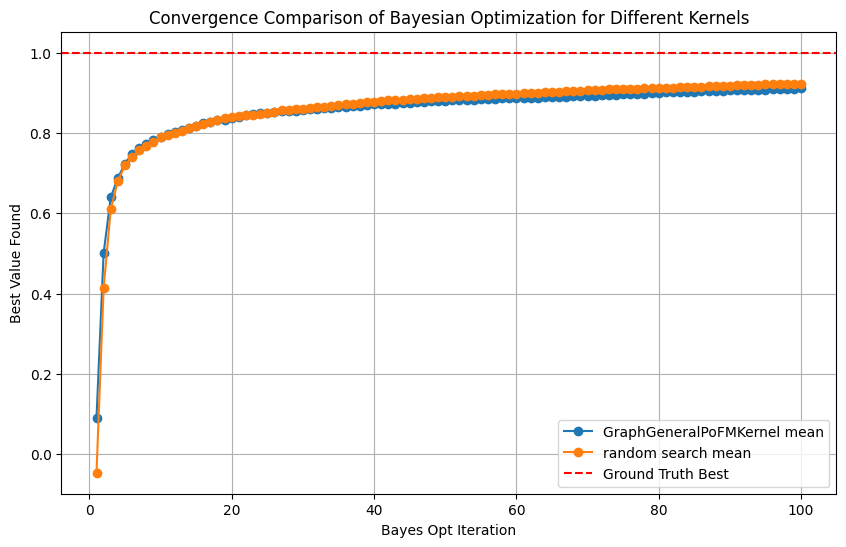

In [327]:
agg_df = convergence_df.groupby(['kernel', 'iteration'], as_index=False).agg(
    best_value_mean=('best_value', 'mean'),
    best_value_std=('best_value', 'std'),
    best_value_min=('best_value', 'min'),
    best_value_max=('best_value', 'max'),
    ground_truth_best=('ground_truth_best', 'first')
)

# Compute regret statistics
agg_df['regret_mean'] = agg_df['ground_truth_best'] - agg_df['best_value_mean']
agg_df['regret_min'] = agg_df['ground_truth_best'] - agg_df['best_value_max']  # max best_value → min regret
agg_df['regret_max'] = agg_df['ground_truth_best'] - agg_df['best_value_min']  # min best_value → max regret

plt.figure(figsize=(10, 6))
for kernel in agg_df['kernel'].unique():
    sub_df = agg_df[agg_df['kernel'] == kernel].copy()
    # Ensure the data is in float format
    sub_df['iteration'] = sub_df['iteration'].astype(float)
    sub_df['best_value_mean'] = sub_df['best_value_mean'].astype(float)
    sub_df['best_value_std'] = sub_df['best_value_std'].astype(float)
    
    x = sub_df['iteration'].values
    y = sub_df['best_value_mean'].values
    y_err = sub_df['best_value_std'].values
    plt.plot(x, y, marker='o', label=f'{kernel} mean')

# Plot ground truth best as a horizontal line
gt_best = 1
plt.axhline(y=gt_best, color='red', linestyle='--', label='Ground Truth Best')

plt.xlabel('Bayes Opt Iteration')
plt.ylabel('Best Value Found')
plt.title('Convergence Comparison of Bayesian Optimization for Different Kernels')
plt.legend()
plt.grid(True)
plt.show()


In [315]:
df = convergence_df.copy()

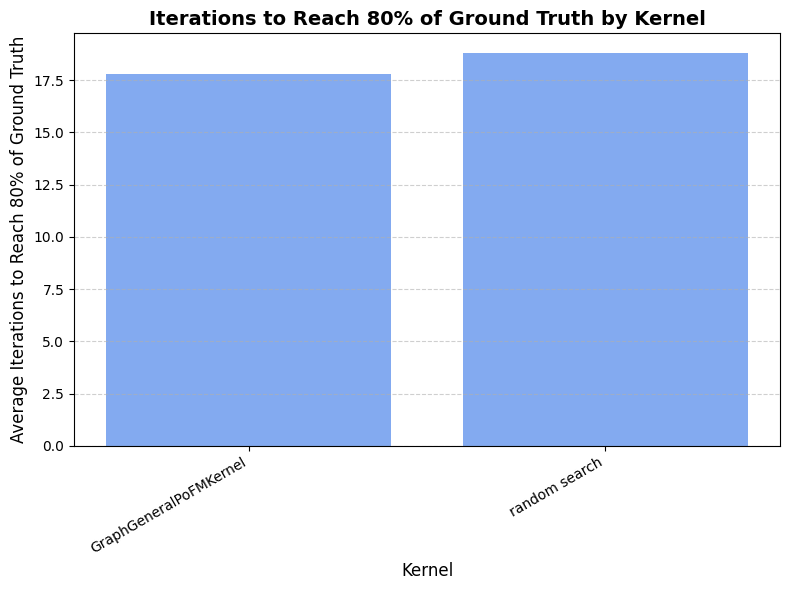

In [324]:
# Define threshold and max iteration
threshold = 0.8
max_iter = df['iteration'].max()  # or set manually as 30
df['best_value'] = df['best_value'].astype(float)
df['reached_threshold'] = df['best_value'] >= threshold

# Step 1: Get first iteration where threshold is reached
reached_df = df[df['reached_threshold']].groupby(['kernel', 'seed'], as_index=False).agg(
    first_iteration=('iteration', 'min')
)

# Step 2: Get all (kernel, seed) pairs
all_pairs = df[['kernel', 'seed']].drop_duplicates()

# Step 3: Merge and fill missing with max_iter
threshold_df = pd.merge(all_pairs, reached_df, on=['kernel', 'seed'], how='left')
threshold_df['first_iteration'] = threshold_df['first_iteration'].fillna(max_iter)

# Step 4: Compute stats per kernel
threshold_stats = threshold_df.groupby('kernel', as_index=False).agg(
    mean_iterations=('first_iteration', 'mean'),
    std_iterations=('first_iteration', 'std')
)

# Step 5: Plot
plt.figure(figsize=(8, 6))
x = range(len(threshold_stats))
y = threshold_stats['mean_iterations']
y_err = threshold_stats['std_iterations']
bars = plt.bar(x, y, capsize=6, alpha=0.8, color='cornflowerblue')

plt.xticks(x, threshold_stats['kernel'], rotation=30, ha='right')
plt.xlabel('Kernel', fontsize=12)
plt.ylabel(f'Average Iterations to Reach {int(threshold*100)}% of Ground Truth', fontsize=12)
plt.title(f'Iterations to Reach {int(threshold*100)}% of Ground Truth by Kernel', fontsize=14, fontweight='bold')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


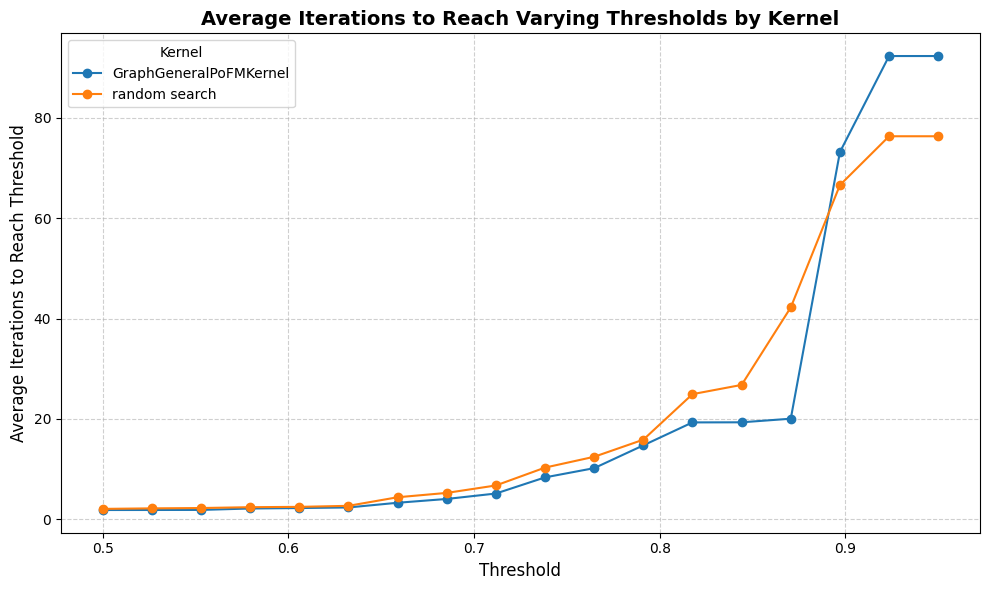

In [326]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Ensure best_value is float
df['best_value'] = df['best_value'].astype(float)

# Set thresholds and initialize list for results
thresholds = np.linspace(0.5, 0.95, 18)  # You can adjust granularity
max_iter = df['iteration'].max()

records = []

# Loop over thresholds and compute average first iteration per kernel
for threshold in thresholds:
    df['reached_threshold'] = df['best_value'] >= threshold

    reached_df = df[df['reached_threshold']].groupby(['kernel', 'seed'], as_index=False).agg(
        first_iteration=('iteration', 'min')
    )

    all_pairs = df[['kernel', 'seed']].drop_duplicates()

    threshold_df = pd.merge(all_pairs, reached_df, on=['kernel', 'seed'], how='left')
    threshold_df['first_iteration'] = threshold_df['first_iteration'].fillna(max_iter)

    stats = threshold_df.groupby('kernel', as_index=False).agg(
        mean_iterations=('first_iteration', 'mean')
    )
    stats['threshold'] = threshold
    records.append(stats)

# Combine all stats into one DataFrame
plot_df = pd.concat(records)

# Plot
plt.figure(figsize=(10, 6))
for kernel in plot_df['kernel'].unique():
    kernel_df = plot_df[plot_df['kernel'] == kernel]
    plt.plot(kernel_df['threshold'], kernel_df['mean_iterations'], label=kernel, marker='o')

plt.xlabel('Threshold', fontsize=12)
plt.ylabel('Average Iterations to Reach Threshold', fontsize=12)
plt.title('Average Iterations to Reach Varying Thresholds by Kernel', fontsize=14, fontweight='bold')
plt.legend(title='Kernel')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


## 2 Learn the Hyperparameters Directly with GRF

### 2.1 Track how the Gram Matrix Converges to the PoFM

In [ ]:
# Define the range of walk lengths
walks_per_nodes = [1,2,4,8,16,32,64,128,256,512,1024,2048,4096,8192]
grf_gram_matrices = []


# This beta value is previosuly learned from the PoFM kernel
beta_test = learned_hyperparameters['beta']

pofm_kernel = GraphDiffusionPoFMKernel(adjacency_matrix,
                                       max_expansion=MAX_WALK_LENGTH,
                                       normalize_laplacian=True)

gram_pofm = pofm_kernel.compute_diffusion_kernel(adjacency_matrix, beta_test, MAX_WALK_LENGTH) # note sigma_f = 1 is used here

for walks_per_node in tqdm(walks_per_nodes, desc='Walk lengths'):
    # Create the graph kernel with the current walk length
    graph_kernel = GraphDiffusionFastGRFKernel(adjacency_matrix,
                                               walks_per_node=walks_per_node,
                                               p_halt=0.1,
                                               max_walk_length=5+1,
                                               normalize_laplacian=True)
    # Learn the hyperparameters directly with GRF
    model, mean, stddev = gp_training(X_train, Y_train, X_full, graph_kernel)
    grf_learned_beta = model.kernel.beta.numpy()
    grf_gram_matrices.append(graph_kernel.grf_kernel(beta=grf_learned_beta, sigma_f=1))

In [ ]:
# Calculate Frobenius norms
frobenius_norms = [compute_fro(gram_pofm, grf_gram) for grf_gram in grf_gram_matrices]

# Plot Frobenius norm vs. Number of Walkers
plt.figure(figsize=(8, 6))
plt.plot(walks_per_nodes, frobenius_norms, marker='o', linestyle='-', color='b')
plt.xlabel('Number of Walkers')
plt.xscale('log')
plt.ylabel('Frobenius Norm')
plt.yscale('log')
plt.title('Frobenius Norm vs Number of Walkers (GRF-Learned Hyperparam)')
plt.grid(True)
plt.show()

### 2.2 Track the L2 Error for Prediction 


We expect this to reach similar level of performance as the truncated diffusion kernel (PoFM)

The fact that we can learn the hyperparam (beta) means that this should looks better than simply comparing the frobenious norm between the PoFM gram matrix and the GRF gram matrix - although they would converge eventually.

In the later code, we learned these two GRF kernels:

1. A GRF kernel that use a diffusion kernel to parameterise the modulation function (hence a Diffusion-shape GRF kernel)
2. A GRF kernel with arbitray modulation function

In [ ]:
# This is when we use GRF to learn a Diffusion-shaped Kernel

walks_per_nodes = [1,2,4,8,16,32,64,128,256,512,1024,2048,4096,8192]
grf_metrics = []


for walks_per_node in tqdm(walks_per_nodes, desc='Walk lengths'):
    # Create the graph kernel with the current walk length
    graph_kernel = GraphDiffusionFastGRFKernel(adjacency_matrix,
                                               walks_per_node=walks_per_node,
                                               p_halt=0.1,
                                               max_walk_length=MAX_WALK_LENGTH+1,
                                               beta = learned_hyperparameters['beta'],
                                               normalize_laplacian=True)
    
    # model = gpflow.models.GPR(data=(X_train, Y_train), kernel=graph_kernel, mean_function=None,noise_variance=0.01)
    # model = configure_model(model, learned_hyperparameters)
    # mean, stddev = gp_inference(model, X_full)
    model, mean, stddev = gp_training(X_train, Y_train, X_full, graph_kernel)
    train_likelihood, l2_error, test_likelihood = evaluate(model, x_test, y_test, quiet=True)
    results = {'walks_per_node': walks_per_node,
                'train_likelihood': train_likelihood,
                'l2_error': l2_error,
                'test_likelihood': test_likelihood}
    grf_metrics.append(results)


In [ ]:
walks_per_nodes = [1,2,4,8,16,32,64,128,256,512,1024,2048,4096,8192]
a_grf_metrics = []


for walks_per_node in tqdm(walks_per_nodes, desc='Walk lengths'):
    # Create the graph kernel with the current walk length
    graph_kernel = GraphGeneralFastGRFKernel(adjacency_matrix,
                                             walks_per_node=walks_per_node,
                                             p_halt=0.1,
                                             max_walk_length=MAX_WALK_LENGTH,
                                             modulator_vector=None) # Randomly initialize the modulator vector
    
    model, mean, stddev = gp_training(X_train, Y_train, X_full, graph_kernel)
    train_likelihood, l2_error, test_likelihood = evaluate(model, x_test, y_test, quiet=True)
    results = {'walks_per_node': walks_per_node,
                'train_likelihood': train_likelihood,
                'l2_error': l2_error,
                'test_likelihood': test_likelihood}
    a_grf_metrics.append(results)


In [ ]:
sns.set(style="whitegrid")

# Define color palette
palette = sns.color_palette("colorblind", n_colors=4)
color_diffusion = palette[0]  # Shared color for GRF Diff & PoFM Diff
color_arbitrary = palette[1]  # Shared color for GRF Arb & PoFM Arb
color_reasonable = palette[2]  # Diffusion reasonable length scale
color_large = palette[3]  # Diffusion very large length scale

plt.figure(figsize=(8, 6))

# Plot GRF curves
plt.plot(walkers_grf, l2_errors_grf, marker='o', linestyle='-', color=color_diffusion,
         label='GRF L2 Error (Diffusion Shape Kernel)')
plt.plot(walkers_a_grf, l2_errors_a_grf, marker='o', linestyle='-', color=color_arbitrary,
         label='GRF L2 Error (Arbitrary Kernel)')

# Plot PoFM horizontal lines with matching colors
plt.axhline(y=pofm_l2_error, color=color_diffusion, linestyle='--',
            label='PoFM L2 Error (Diffusion Shape Kernel)')
plt.axhline(y=g_pofm_l2_error, color=color_arbitrary, linestyle='--',
            label='PoFM L2 Error (Arbitrary Kernel)')

# Diffusion horizontal lines
plt.axhline(y=diffusion_l2_error, color=color_reasonable, linestyle='--',
            label='Diffusion L2 Error (Reasonable Length Scale)')
plt.axhline(y=o_diffusion_l2_error, color=color_large, linestyle='--',
            label='Diffusion L2 Error (Very Large Length Scale)')

# Labels and formatting
plt.xlabel('Number of Walkers')
plt.xscale('log')
plt.ylabel('L2 Error')
plt.yscale('log')
plt.title('L2 Error vs Number of Walkers')

plt.legend()
plt.grid(True)
plt.show()

## 3. Performance of the GRF Approximated Diffusion Kernel

Takes roughly 20 mins to run

### 3.1 Track the Convergence of the Gram Matrix

In [ ]:
# Define the range of walk lengths
walks_per_nodes = [1,2,4,8,16,32,64,128,256,512,1024,2048,4096,8192]
grf_gram_matrices = []

beta_test = learned_hyperparameters['beta']
# beta_test = 0.1

pofm_kernel = GraphDiffusionPoFMKernel(adjacency_matrix,
                                       max_expansion=MAX_WALK_LENGTH,
                                       normalize_laplacian=True)

gram_pofm = pofm_kernel.compute_diffusion_kernel(adjacency_matrix, beta_test, MAX_WALK_LENGTH) # note sigma_f = 1 is used here

for walks_per_node in tqdm(walks_per_nodes, desc='Walk lengths'):
    # Create the graph kernel with the current walk length
    graph_kernel = GraphDiffusionFastGRFKernel(adjacency_matrix,
                                               walks_per_node=walks_per_node,
                                               p_halt=0.1,
                                               max_walk_length=5+1,
                                               normalize_laplacian=True)
    grf_gram_matrices.append(graph_kernel.grf_kernel(beta=beta_test, sigma_f=1))

In [ ]:
# Calculate Frobenius norms
frobenius_norms = [compute_fro(gram_pofm, grf_gram) for grf_gram in grf_gram_matrices]

# Plot Frobenius norm vs. Number of Walkers
plt.figure(figsize=(8, 6))
plt.plot(walks_per_nodes, frobenius_norms, marker='o', linestyle='-', color='b')
plt.xlabel('Number of Walkers')
plt.xscale('log')
plt.ylabel('Frobenius Norm')
plt.yscale('log')
plt.title('Frobenius Norm vs Number of Walkers')
plt.grid(True)
plt.show()

### 3.2 Track the Convergence of L2 Error

In [ ]:
walks_per_nodes = [1,2,4,8,16,32,64,128,256,512,1024,2048,4096,8192]
grf_metrics = []


for walks_per_node in tqdm(walks_per_nodes, desc='Walk lengths'):
    # Create the graph kernel with the current walk length
    graph_kernel = GraphDiffusionFastGRFKernel(adjacency_matrix,
                                               walks_per_node=walks_per_node,
                                               p_halt=0.1,
                                               max_walk_length=MAX_WALK_LENGTH+1,
                                               beta = learned_hyperparameters['beta'],
                                               normalize_laplacian=True)
    
    model = gpflow.models.GPR(data=(X_train, Y_train), kernel=graph_kernel, mean_function=None,noise_variance=0.01)
    model = configure_model(model, learned_hyperparameters)
    mean, stddev = gp_inference(model, X_full)
    train_likelihood, l2_error, test_likelihood = evaluate(model, x_test, y_test, quiet=True)
    results = {'walks_per_node': walks_per_node,
                'train_likelihood': train_likelihood,
                'l2_error': l2_error,
                'test_likelihood': test_likelihood}
    grf_metrics.append(results)


In [ ]:
# Extract the number of walkers and corresponding L2 errors from grf_metrics
walkers = [metric['walks_per_node'] for metric in grf_metrics]
l2_errors = [metric['l2_error'] for metric in grf_metrics]

# Plot the L2 error vs. number of walkers
plt.figure(figsize=(8, 6))
plt.plot(walkers, l2_errors, marker='o', linestyle='-', color='b', label='GRF L2 Error')
plt.axhline(y=diffusion_l2_error, color='r', linestyle='--', label='Exact Diffusion L2 Error')
plt.axhline(y=pofm_l2_error, color='g', linestyle='--', label='PoFM L2 Error')
plt.xlabel('Number of Walkers')
plt.xscale('log')
plt.ylabel('L2 Error')
plt.yscale('log')
plt.title('L2 Error vs Number of Walkers')
plt.legend()
plt.grid(True)
plt.show()

## 4. Performance of the GRF-based non-Diffusion Kernel (with Arbitrary Modulation Function)

We can learn a broader family of graph kernel with arbitrary modulation function, in our example we got better l2 error.

### 4.1 First Learn the Hyperparamters for Arbitrary Modulation Functions

In [ ]:
# The normalized laplacian is used
graph_kernel = GraphGeneralPoFMKernel(adjacency_matrix,
                                      max_walk_length=MAX_WALK_LENGTH,
                                      normalize_laplacian=True) # note a random initialization of modulation function is used.

model, mean, stddev = gp_training(X_train, Y_train, X_full, graph_kernel)
print_summary(model)

In [ ]:
g_pofm_train_likelihood, g_pofm_l2_error, g_pofm_test_likelihood = evaluate(model, x_test, y_test)

In [ ]:
g_learned_hyperparameters = {
    "modulator_vector": model.kernel.modulator_vector.numpy(),
    "variance": model.likelihood.variance.numpy()
}

g_learned_hyperparameters["modulator_vector"]

### 4.2 (Opt) Compare with the actual modulation function learned with diffusion kernel

In [ ]:
sample_beta = 2.87312 
sample_sigma_f = 1.51095

def diffusion_modulator_np(length: np.ndarray, beta: float) -> np.ndarray:
    length = length.astype(np.float64)
    beta = np.float64(beta)  # Ensure beta is a float
    two = np.float64(2.0)
    
    # Compute numerator safely
    numerator = np.power(np.abs(beta), length) * (-1) ** length  
    denominator = np.power(two, length) * np.exp(scipy.special.gammaln(length + 1.0))
    
    return numerator / denominator

# Compute the diffusion modulator vector
example_diffusion_modulator_vector = (
    sample_sigma_f**2 * diffusion_modulator_np(
        length=np.arange(MAX_WALK_LENGTH),  # Generate length array
        beta=sample_beta  # Pass scalar beta
    )
)

example_diffusion_modulator_vector

### 4.3 Performance of the GRF-Approximated Kernel

#### 4.3.1 Gram Matrices

In [ ]:
# Define the range of walk lengths
walks_per_nodes = [1,2,4,8,16,32,64,128,256,512,1024,2048,4096,8192,16384,32768]
grf_gram_matrices = []

# beta_test = 0.1

pofm_kernel = GraphGeneralPoFMKernel(adjacency_matrix,
                                      max_walk_length=MAX_WALK_LENGTH,
                                      normalize_laplacian=True) # note a random initialization of modulation function is used.


gram_pofm = pofm_kernel.pofm_kernel(modulator_vector=g_learned_hyperparameters["modulator_vector"])

for walks_per_node in tqdm(walks_per_nodes, desc='Walk lengths'):
    # Create the graph kernel with the current walk length
    graph_kernel = GraphGeneralFastGRFKernel(adjacency_matrix,
                                             walks_per_node=walks_per_node,
                                             p_halt=0.1,
                                             max_walk_length=MAX_WALK_LENGTH,
                                             modulator_vector=g_learned_hyperparameters["modulator_vector"])
    grf_gram_matrices.append(graph_kernel.grf_kernel(modulator_vector=g_learned_hyperparameters["modulator_vector"]))

In [ ]:
# Calculate Frobenius norms
frobenius_norms = [compute_fro(gram_pofm, grf_gram) for grf_gram in grf_gram_matrices]

# Plot Frobenius norm vs. Number of Walkers
plt.figure(figsize=(8, 6))
plt.plot(walks_per_nodes, frobenius_norms, marker='o', linestyle='-', color='b')
plt.xlabel('Number of Walkers')
plt.xscale('log')
plt.ylabel('Frobenius Norm')
plt.yscale('log')
plt.title('Frobenius Norm vs Number of Walkers')
plt.grid(True)
plt.show()

In [ ]:
gram_pofm

In [ ]:
grf_gram_matrices[-1]

#### 4.3.2 L2 Error

In [ ]:
walks_per_nodes = [1,2,4,8,16,32,64,128,256,512,1024,2048,4096,8192,16384,32768]
grf_metrics = []


for walks_per_node in tqdm(walks_per_nodes, desc='Walk lengths'):
    # Create the graph kernel with the current walk length
    graph_kernel = GraphGeneralFastGRFKernel(adjacency_matrix,
                                             walks_per_node=walks_per_node,
                                             p_halt=0.1,
                                             max_walk_length=MAX_WALK_LENGTH,
                                             modulator_vector=g_learned_hyperparameters["modulator_vector"])
    
    model = gpflow.models.GPR(data=(X_train, Y_train), kernel=graph_kernel, mean_function=None,noise_variance=0.01)
    model = configure_model_general(model, g_learned_hyperparameters)
    mean, stddev = gp_inference(model, X_full)
    train_likelihood, l2_error, test_likelihood = evaluate(model, x_test, y_test, quiet=True)
    results = {'walks_per_node': walks_per_node,
                'train_likelihood': train_likelihood,
                'l2_error': l2_error,
                'test_likelihood': test_likelihood}
    grf_metrics.append(results)


In [ ]:
# Extract the number of walkers and corresponding L2 errors from grf_metrics
walkers = [metric['walks_per_node'] for metric in grf_metrics]
l2_errors = [metric['l2_error'] for metric in grf_metrics]

# Plot the L2 error vs. number of walkers
plt.figure(figsize=(8, 6))
plt.plot(walkers, l2_errors, marker='o', linestyle='-', color='b', label='GRF L2 Error (General)')
plt.axhline(y=g_pofm_l2_error, color='g', linestyle='--', label='PoFM L2 Error (General)')
plt.xlabel('Number of Walkers')
plt.xscale('log')
plt.ylabel('L2 Error')
plt.yscale('log')
plt.title('L2 Error vs Number of Walkers')
plt.legend()
plt.grid(True)
plt.show()

## 5. Next Steps: Learn the Hyperparamter with GRF


Using GRF to learn hyperparam:
1. in practice use GRF for everything - yes
2. PoFM: best possible hyperparam with infinite number of walks - yes
3. we expect GRF to learn smaller beta (designed for smaller number of walks) - yes
4. rethink the samping destribution - doing 